# Convolutional Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [7]:
# !pip install cartopy xarray matplotlib netCDF4 torch torchinfo

In [31]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

import sys
sys.path.append('/kaggle/input/helper-functions/')
import helper_functions     # Own file.
import importlib
importlib.reload(helper_functions)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Architecture

In [4]:
class CAE(nn.Module):
    def __init__(self, in_channels, latent_dim=3, dropout_p=0.2, channels=[32, 64, 128], input_shape=(203, 514)):
        super().__init__()

        self.input_shape = input_shape
        self.channels = channels

        encoder_layers = []
        prev_channels = in_channels
        h, w = input_shape

        for ch in channels:
            encoder_layers += [
                nn.Conv2d(prev_channels, ch, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ch),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]
            prev_channels = ch
            h = math.floor((h + 2 * 1 - 3) / 2 + 1)  # Conv2d output size formula
            w = math.floor((w + 2 * 1 - 3) / 2 + 1)

        self.encoder = nn.Sequential(*encoder_layers)
        self.unflatten_shape = (channels[-1], h, w)

        flat_dim = channels[-1] * h * w
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Sequential(
            nn.Linear(flat_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, latent_dim)
        )
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, flat_dim)
        )

        decoder_layers = []
        rev_channels = list(reversed(channels))
        for i in range(len(rev_channels) - 1):
            decoder_layers += [
                nn.ConvTranspose2d(rev_channels[i], rev_channels[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(rev_channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]

        decoder_layers += [
            nn.ConvTranspose2d(rev_channels[-1], in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x, mask=None):
        if mask is not None:
            x = x * mask
        x = self.encoder(x)
        z = self.fc_enc(self.flatten(x))
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.unflatten_shape)
        x = self.decoder(x)
        return x[:, :, :self.input_shape[0], :self.input_shape[1]]


In [10]:
def masked_mse(x_recon, x_true, mask):
    loss = ((x_recon - x_true) ** 2) * mask
    return loss.sum() / mask.sum()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAE(in_channels=X_np.shape[1], latent_dim=3, dropout_p=0.1, channels= [32, 64, 128, 256, 512, 1024]).to(device)
model.load_state_dict(torch.load("../models/ConvAE.pth"))

<All keys matched successfully>

## Reconstructing

In [20]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")

X_np, M_np = helper_functions.preprocessing_conv(ds, ["thetao", "so"], [50, 300, 1000], 1)
X = torch.tensor(X_np)  # (B, C, H, W)
M = torch.tensor(M_np)
print(X.shape)

In [6]:
X_recon_all = helper_functions.reconstruct_in_batches(X, model, device, batch_size=16)

M_tensor = torch.tensor(M_np[:, :, :203, :514], dtype=torch.float32)
valid_flat_mask = (M_tensor[0] > 0).reshape(-1).cpu().numpy()

X_recon_all = helper_functions.reconstruction_to_vector_masked_positions(X_recon_all, valid_flat_mask)

/home/jovyan/spatiotemporal-mining-medsea/evaluation/helper_functions.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(device))


/home/jovyan/spatiotemporal-mining-medsea/evaluation/helper_functions.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(device))


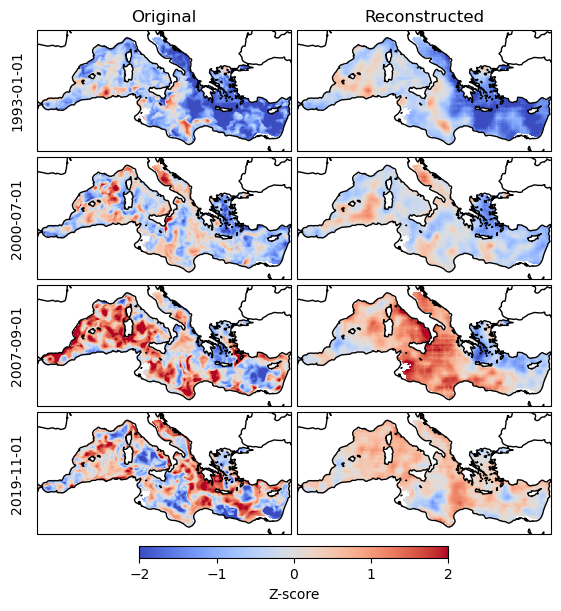

In [8]:
original_z = helper_functions.preprocessing(ds, ["thetao"], [50], "location", -1)

# Getting the mask
M_mask = M_tensor[0].reshape(-1) > 0  # (C * H * W,)

# Reconstruction of the stacked z_vector
X_recon = helper_functions.reconstruct_in_batches(X, model, device, batch_size=16)

# Get valid positions.
flat_recon = helper_functions.reconstruction_to_vector_masked_positions(X_recon, M_mask)
coords = original_z.location  # z. B. aus dem preprocessing()
reconstructed_z = helper_functions.reconstructed_to_stack(ds, "thetao", 50, flat_recon, coords)

helper_functions.plot_reconstruction_comparison(
    z_stack_original=original_z,
    z_stack_recon=reconstructed_z,
    time_indices=[0, 90, 176, 322],
    cmin=-2,
    cmax=2
)

## Clustering with K-Means

### Clustering the reconstructions

### Latent = 42

In [9]:
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/evaluation/helper_functions.py'>

In [10]:
k=9
labels = helper_functions.apply_kmeans(X_recon_all, k)
labels += 1

### Depth = 50

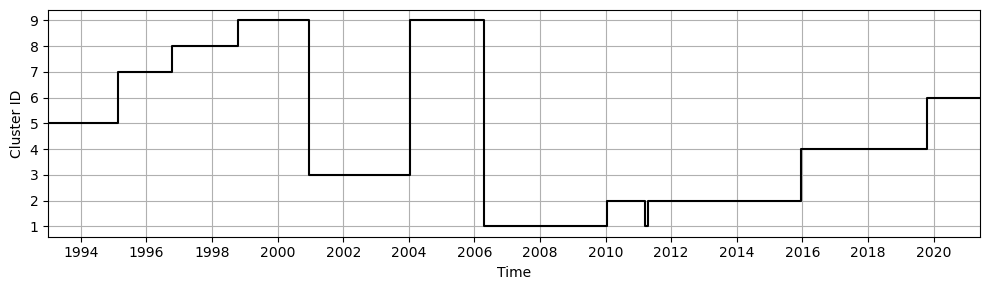

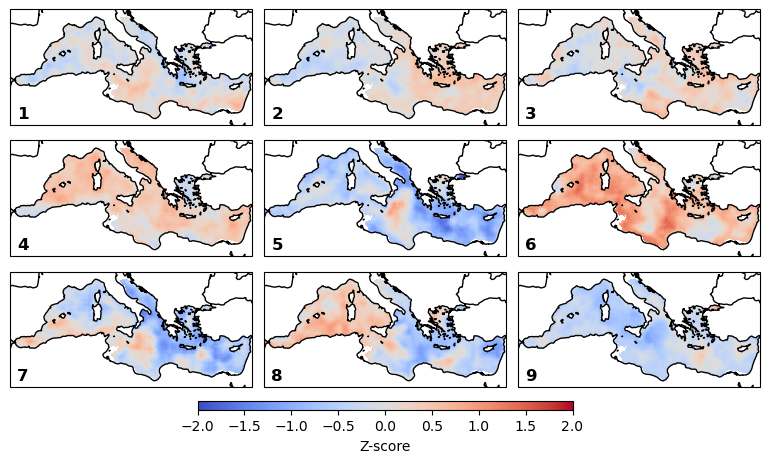

In [13]:
coords = helper_functions.preprocessing(ds, ["thetao"], [50], "location", -1).location
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all, coords)

helper_functions.plot_cluster_timeline(recon_temp_50, labels)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

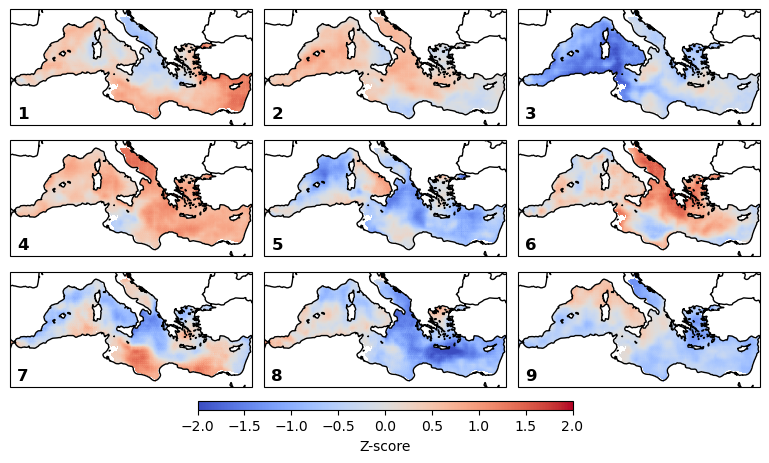

In [14]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

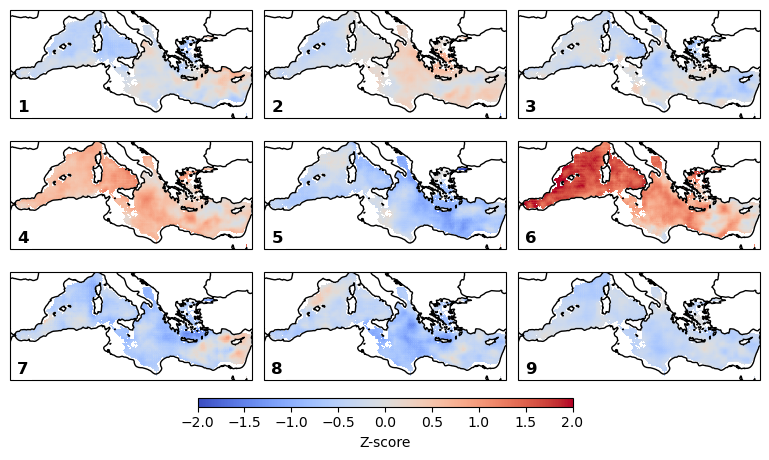

In [15]:
coords = helper_functions.preprocessing(ds, ["thetao"], [300], "location", -1).location
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

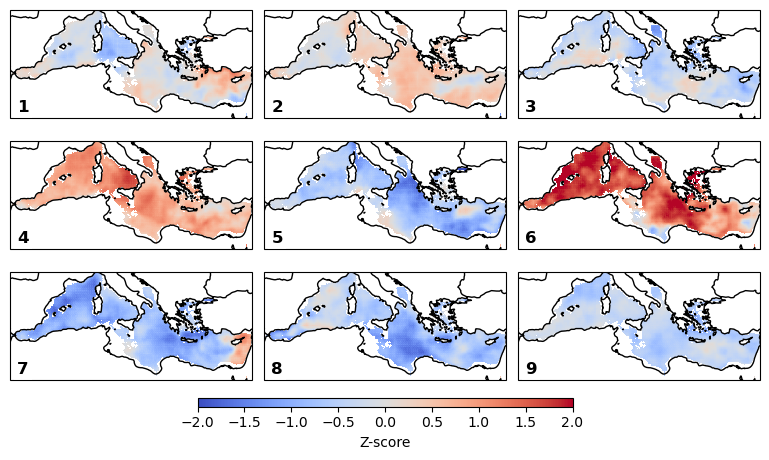

In [17]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all,coords)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

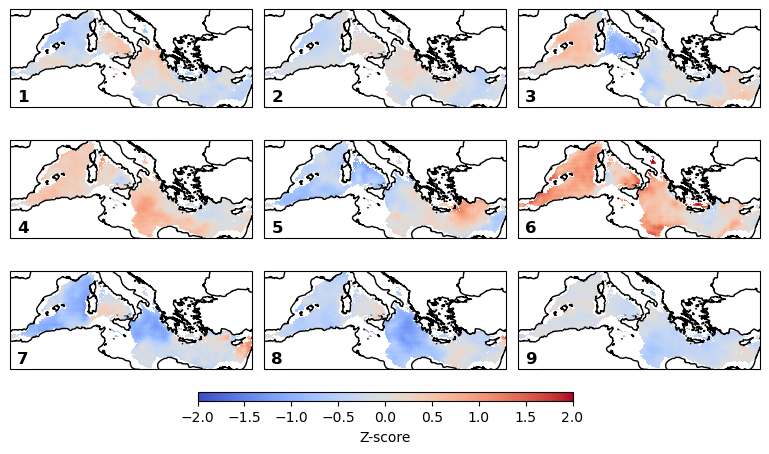

In [18]:
coords = helper_functions.preprocessing(ds, ["thetao"], [1000], "location", -1).location
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 1000, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_temp_1000, labels, -2, 2)

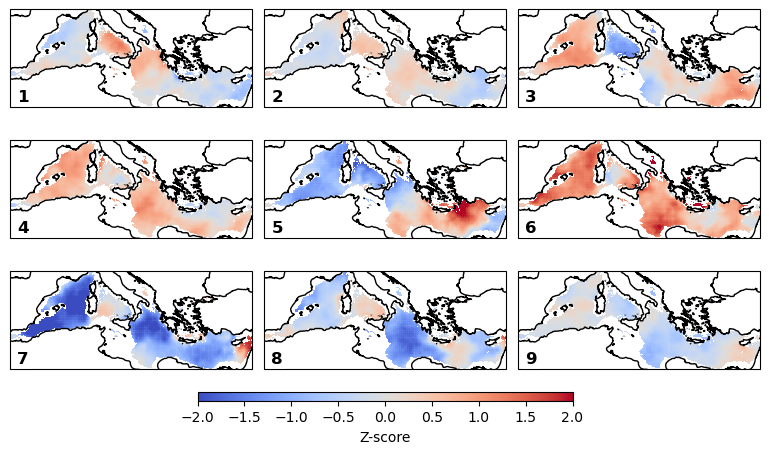

In [19]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all, coords)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)

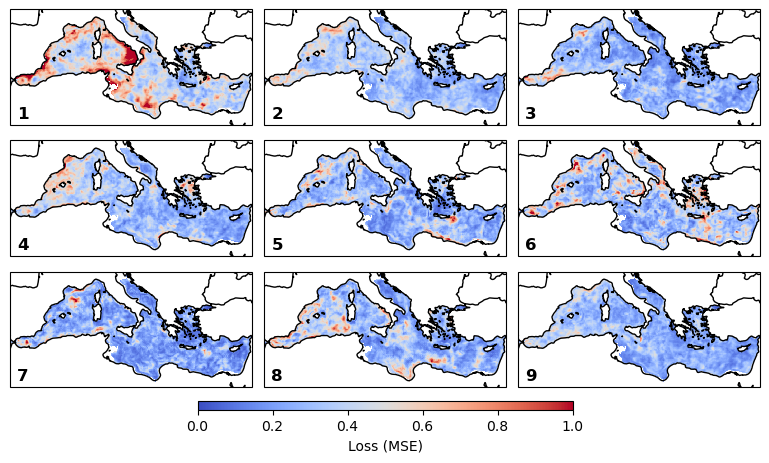

In [32]:
helper_functions.plot_average_loss_map_from_data(original_z, reconstructed_z, labels, 0, 1)
